# FINM 33150 | Final Project Draft

Stephen Coley, Harrison Holt, Josh, Kyle Parran

Feb-24-2025

## The Task

The end goal here is to invent, simulate, and analyze a quantitative trading strategy.

Our initial ideas for a strategy include:


Once we determine a viable strategy we will need to ensure such a strategy has the following features:
- Investment in publicly traded (but not necessarily electronically traded) assets
- A "recipe" for evaluating attractiveness of potential trades that
    - depend on pre-specified classes of info
    - could be followed by anyone, given the recipe and data sources
- A "recipe" for investment sizes, and position entry and exit rules, that
    - may link position size to attractiveness
    - ensures risk stays within limits and capital remains bounded
    - makes reasonable assumptions about entry and exit liquidity

Elements of trading strategies include lead-lag relationships, market making, carry trades, pair trading, factor investment, model reversion, merger arbitrage, technical signals, etc.

Our strategy should have the following features:
- Significant dependence on at least one class of information that is not twitter, equity ohlc, equity VWAPs, or equity trading volumes, unelss at a relatively high frequency (600 secs or less)
- As of at least some times in your simulation, simultaneously holds at least 5 distinct assets (different currencies, commodities, option maturities/strikes etc.)
- Produces a total of 40 trades or more over your entire analysis/simulation period, without excessive clustering
- Leverage, with documented and reasonable capital and risk control assumptions


## Outline

### 1. Introduction

### 2. Data Assembly

### 3. Data Analysis

--------Next Phase--------

### 4. Strategy Implementation

### 6. Backtesting

### 7. Performance Analysis

### 8. References

## Introduction

### Strategy Overview
The end goal here is to create a quantile trading strategy that ranks equities based on their expected drift after the initial earnings surprise announcement. We estimate this expected drift by taking the percentage earnings surprise each quarter for a limited amount of equities and then compare that to the next day price move of that equity. Hopefully, the less the price move is relative to the earnings surprise, the more there is to capture in the post-drift. For metric standardization purposes, we will z-score this metric, "surprise vs. price move" within a separated bin based on the average EPS size to minimize the effects of large surprises versus small estimates. For diversification purposes we will also add in some other fundamental and technical indicators related to growth and momentum and Z-score those as well in a similar manner. To begin, we will weight the z-score of the "surprise vs. price move" metric more heavily, as we use that as our thesis, and vary the weights of the other indicators as we see the results. More information about data collection, order execution, and risk and liquidity constraints can be found below. 

Data Acquisition
- EPS Actual Data and Consensus Estimates/Surprise Metrics for Equities from WRDS I/B/E/S
- Equity close prices from NASDAQ's 'QUOTEMEDIA/PRICES' dataset
- Fundamental and market value data from NASDAQ's ZACKS Fundamental B dataset
- Execution data from WRDS BARS dataset

Additional Constraints/Specifications
- To minimize risk we plan on taking a long/short quantile approach as well as instituting a stop loss of 10% on any stock
- In addition, we will limit position sizes of any individual stock to 5% of the total portfolio
- We plan on acquiring larger position sizes up to the limitations above on a particular percentage of the quantile we choose.
- We have limited the equities to an investable universe of companies that haven't dipped below $500 million in market value within the time period, to ensure reasonable liquidity.
- Based on the lookback period below, We will start out with 10*gross notional of our first position,which we will borrow at OIS+50bps. Subsequently, every rebalance/lookback period, we will adjust the capital based on the unrealized an realized P&L of our holdings. We will maintain the 10x leverage based on the capital throughout the lifecycle of the strategy

Constraints/Parameters we will test/vary as we implement out approach
- Quantile size(q)
    - The way we invest in quantiles will also be modified as we will weight better and worse rankings within each quantile differently.

- Lookback Period(L) - We will look at both results for a lookback period of 3 months and shorter periods to re-sort our quantile rankings
    - In the 3 - month approach, the strategy is minimally dynamic and we will adapt the portfolio holdings every 3-months based on the new rankings for the quarter
    - In the shorter period lookbacks, we will keep a running tally of rankings, adding equities to the rankings once a certain amount of equities earnings have been announced, and we will re-evaluate rankings and portfolio holdings after every subsequent L period.

## Setup

In [1]:
import pandas as pd
import numpy as np
import nasdaqdatalink as ndl
import quandl
import wrds
from dotenv import load_dotenv
import os
import datetime
from datetime import timedelta
from plotnine import ggplot, aes, geom_line, scale_color_manual, geom_hline, labs, theme, element_text, facet_wrap, geom_histogram, ggtitle, geom_boxplot, stat_function, geom_density
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
import functools
from scipy.stats import zscore
from sklearn.decomposition import PCA
from functools import lru_cache
import pytz

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

load_dotenv()

ndl.ApiConfig.api_key = os.getenv('NDL_API_KEY')
quandl_api_key = os.getenv('NDL_API_KEY')
wrds_username = os.getenv('WRDS_USERNAME')
adv_api_key = os.getenv('ADV_API_KEY')

db = wrds.Connection(wrds_username=wrds_username, verbose = False)

Loading library list...
Done


## Data Assembly

### Quandl function

In [15]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.path.expanduser("~"), "quandl_data_table_downloads")
    if not os.path.exists(root_data_dir):
        print(f"Directory does not exist. Creating: {root_data_dir}")
        os.makedirs(root_data_dir, exist_ok=True)
    else:
        print(f"Directory already exists: {root_data_dir}")

    data_symlink = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_latest.zip"))

    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)

    print(table_dir)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.normpath(os.path.join(root_data_dir, f"{table_path}_{my_date}.zip"))

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, 
        filename=data_file, 
        api_key=os.getenv('NDL_API_KEY'), 
        **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        print(data_symlink)
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### Data load

#### **Zacks Fundamental B**

| Table                       | Table Code   | Table Description                                                                                                                                                                                                                                                                   |
|-----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fundamentals Condensed      | ZACKS/FC     | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.                                                                                                    |
| Fundamentals Ratios         | ZACKS/FR     | This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.                                                                                                                                                                           |
| Master Table                | ZACKS/MT     | This table contains descriptive information about all tickers that are included in Zacks products.                                                                                                                                                                                   |
| Market Value Supplement     | ZACKS/MKTV   | This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders. |
| Shares Out Supplement       | ZACKS/SHRS   | This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.                                              |
| Historical Daily Maintenance| ZACKS/HDM    | This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events. |

In [16]:
start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'
start_filter_date = '2019-01-01'
end_filter_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year

year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

zacks_fc = fetch_quandl_table('ZACKS/FC', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_fr = fetch_quandl_table('ZACKS/FR', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_mt = fetch_quandl_table('ZACKS/MT', avoid_download=True)
zacks_mktv = fetch_quandl_table('ZACKS/MKTV', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_shrs = fetch_quandl_table('ZACKS/SHRS', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_hdm = fetch_quandl_table('ZACKS/HDM', avoid_download=True)

zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])+timedelta(days=1)
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_mktv['per_end_date'] = pd.to_datetime(zacks_mktv['per_end_date'])
zacks_shrs['per_end_date'] = pd.to_datetime(zacks_shrs['per_end_date'])
zacks_fc = zacks_fc.dropna(subset=['per_end_date', 'filing_date'])

zacks_df = pd.merge(zacks_fc, zacks_fr, on=['ticker', 'per_end_date', 'per_type'], how='left', suffixes=('_fc', '_fr'))
zacks_df = pd.merge(zacks_df, zacks_mktv, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_df = pd.merge(zacks_df, zacks_shrs, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_df = pd.merge(zacks_df, zacks_mt, on=['ticker'], how='left')

Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/FC
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/FR
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/MT
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/MKTV
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/SHRS
Directory already exists: C:\Users\harri\quandl_data_table_downloads
Skipping any possible download of ZACKS/HDM


In order to avoid issues with illiquid stocks and ensure ample market reaction to earnings we apply a filter criteria when creating our company universe. Based on Zacks Fundamentals, we limited our company universe to firms with greater than a $500 million market value threshold. 

In [6]:
top_stocks = zacks_mktv.loc[(zacks_mktv['per_end_date'] == zacks_mktv.per_end_date.max()) & (zacks_mktv['mkt_val']>=500)].sort_values(by='mkt_val', ascending=False).copy().reset_index(drop=True)
top_tickers = tuple(top_stocks.ticker)
top_tickers_list = list(top_tickers)

print(f"{len(top_tickers):,} tickers with market cap >= 500M")

3,196 tickers with market cap >= 500M


#### **Quandl EOD price data**

When referencing price end of day price data we will utilize Quandl End of Day US Stock Prices. Updated daily, this data feed offers end of day prices, dividends, adjustments and splits for U.S. publicly traded stocks with history to 1996. Prices are provided both adjusted and unadjusted.

Key Features:

- Covers all stocks with primary listing on NASDAQ, AMEX, NYSE and ARCA.
- Includes unadjusted and adjusted open, high, low, close, volume.
- Includes dividend history and split history.
- Updated at or before 5:00 pm ET on all trading days.
- Exchange corrections are applied by 9:30 pm ET.
- Historical data goes back to 1996.

In [ ]:
# eod_data = fetch_quandl_table(
#     'QUOTEMEDIA/PRICES', 
#     avoid_download=True,
# )

# spy_eod_data =  eod_data.loc[
#                             (eod_data.ticker.isin(['SPY']))
#                             & (eod_data.date >= '2014-01-01')
#                             & (eod_data.date <= '2024-12-31')
#                         ].copy()

# spy_eod_data = spy_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

# spy_eod_data.to_parquet('../data/spy_eod_data_2014_2024.parquet')
spy_eod_data = pd.read_parquet('../data/spy_eod_data_2014_2024.parquet')

# top_eod_data = eod_data.loc[
#                             (eod_data.ticker.isin(top_tickers_list))
#                             & (eod_data.date >= '2014-01-01')
#                             & (eod_data.date <= '2024-12-31')
#                         ].copy()

# top_eod_data = top_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

# top_eod_data.to_parquet('../data/top_eod_data_2014_2024.parquet')
top_eod_data = pd.read_parquet('../data/top_eod_data_2014_2024.parquet')

top_eod_data['daily_rets'] = top_eod_data.groupby('ticker')['adj_close'].pct_change()

display(top_eod_data.head())
display(top_eod_data.tail())

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
0,A,2014-01-02,57.10,57.100,56.15,56.21,1916200.0,0.0,1.0,37.731086,37.731086,37.103336,37.142983,1916200.0,NaN,NaN
1,A,2014-01-03,56.39,57.345,56.26,56.92,1866700.0,0.0,1.0,37.261925,37.892979,37.176023,37.612144,1866700.0,0.012631,0.012631
2,A,2014-01-06,57.40,57.700,56.56,56.64,1777300.0,0.0,1.0,37.929323,38.127560,37.374259,37.427123,1777300.0,-0.004919,-0.004919
3,A,2014-01-07,56.95,57.630,56.93,57.45,1463200.0,0.0,1.0,37.631967,38.081304,37.618752,37.962362,1463200.0,0.014301,0.014301
4,A,2014-01-08,57.33,58.540,57.17,58.39,2659500.0,0.0,1.0,37.883067,38.682623,37.777341,38.583504,2659500.0,0.016362,0.016362


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
6649950,ZYME,2025-01-13,13.40,14.07,12.80,13.96,765249.0,0.0,1.0,13.40,14.07,12.80,13.96,765249.0,0.055976,0.055976
6649951,ZYME,2025-01-14,14.14,14.14,13.34,13.62,361021.0,0.0,1.0,14.14,14.14,13.34,13.62,361021.0,-0.024355,-0.024355
6649952,ZYME,2025-01-15,13.96,14.55,13.71,14.04,383988.0,0.0,1.0,13.96,14.55,13.71,14.04,383988.0,0.030837,0.030837
6649953,ZYME,2025-01-16,14.63,14.63,13.75,13.99,513650.0,0.0,1.0,14.63,14.63,13.75,13.99,513650.0,-0.003561,-0.003561
6649954,ZYME,2025-01-17,14.11,14.13,13.58,13.88,323783.0,0.0,1.0,14.11,14.13,13.58,13.88,323783.0,-0.007863,-0.007863


##### Description of EOD Price Data

After applying our filter criteria, the dataset of EOD prices contains over 6.6M observations of EOD prices across multiple tickers.

Price Metrics (`adj_open`, `adj_high`, `adj_low`, `adj_close`)
- Mean Prices:
    - Open: $67.21
    - High: $68.10
    - Low: $66.30
    - Close: $67.21

Price Range:
- Minimum Price: $0.05
- Maximum Price: $9,924.40
- 25th Percentile: $16.37 (lower quartile)
- 50th Percentile (Median): $35.23
- 75th Percentile: $70.95

Price Volatility (Std):
- Standard deviation across prices: ~$166 (high variability, indicating a wide range of stock prices from penny stocks to large-cap stocks).


Trading Volume (`adj_volume`)
- Mean Trading Volume: ~1.99M shares per day
- Volume Range:
    - Minimum: 0 (some days had no trading activity)
    - Maximum: 1.24 billion shares
    - Median: 578,336 shares
    - 75th Percentile: 1.65M shares
- High standard deviation (~6.27M) indicates significant variation in trading volume across different stocks.

Keytakeways
- Highly Diverse Stock Universe: The dataset includes both small-cap and large-cap stocks, as evident from price extremes (from $0.05 to nearly $10,000).
- Significant Price Volatility: The high standard deviation across prices and returns suggests a mix of highly volatile and stable stocks.
- Extreme Trading Volumes: Some stocks trade billions of shares daily, while others have zero volume.

In [11]:
display(top_eod_data.describe())
print(top_eod_data.info())

print("\nSummary of Missing Values by Ticker")
display(top_eod_data.loc[top_eod_data.adj_close.isna()].groupby(['ticker']).size())

,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,daily_rets
count,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.649955e+06,6.646984e+06,6.646984e+06
mean,6.721352e+01,6.810679e+01,6.630100e+01,6.721168e+01,1.997307e+06,3.813917e-03,1.000121e+00,5.999879e+01,6.082987e+01,5.914679e+01,5.999025e+01,2.335207e+06,7.919139e-04,7.919139e-04
std,1.661782e+02,1.682137e+02,1.640939e+02,1.661694e+02,6.266691e+06,3.111383e-01,1.233241e-01,1.584777e+02,1.606942e+02,1.561806e+02,1.583775e+02,1.279472e+07,1.449298e-01,1.449298e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,8.961537e-03,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01,-9.220083e-01
25%,1.638000e+01,1.666000e+01,1.609000e+01,1.637000e+01,1.945335e+05,0.000000e+00,1.000000e+00,1.441000e+01,1.466000e+01,1.415161e+01,1.440409e+01,1.931730e+05,-1.100413e-02,-1.100413e-02
50%,3.523000e+01,3.575000e+01,3.471000e+01,3.523000e+01,5.783360e+05,0.000000e+00,1.000000e+00,3.043648e+01,3.089780e+01,2.997349e+01,3.043583e+01,5.826000e+05,2.575992e-04,2.575992e-04
75%,7.095000e+01,7.185000e+01,7.000000e+01,7.095000e+01,1.650906e+06,0.000000e+00,1.000000e+00,6.200000e+01,6.284000e+01,6.115000e+01,6.200000e+01,1.693571e+06,1.173021e-02,1.173021e-02
max,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,1.244189e+09,5.679717e+02,3.100000e+02,9.914170e+03,9.964770e+03,9.794000e+03,9.924400e+03,3.692928e+09,3.408866e+02,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6649955 entries, 0 to 6649954
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  returns     float64
 15  daily_rets  float64
dtypes: float64(14), object(2)
memory usage: 811.8+ MB
None

Summary of Missing Values by Ticker


Series([], dtype: int64)

Below we analyze the distribution of the daily returns for each ticker to identify any data irregularities.

- Leptokurtic Distribution: The actual distribution has a much sharper peak and fatter tails than a normal distribution, indicating high kurtosis.
- Stock Market Returns are Not Normal: This confirms well-known financial market behavior—returns tend to have fatter tails and more frequent extreme movements (eg large crashes or spikes).
- Risk Implications:
    - Traditional models assuming normality may underestimate risk due to tail risk.
    - Risk management strategies should account for these higher probabilities of extreme losses/gains.

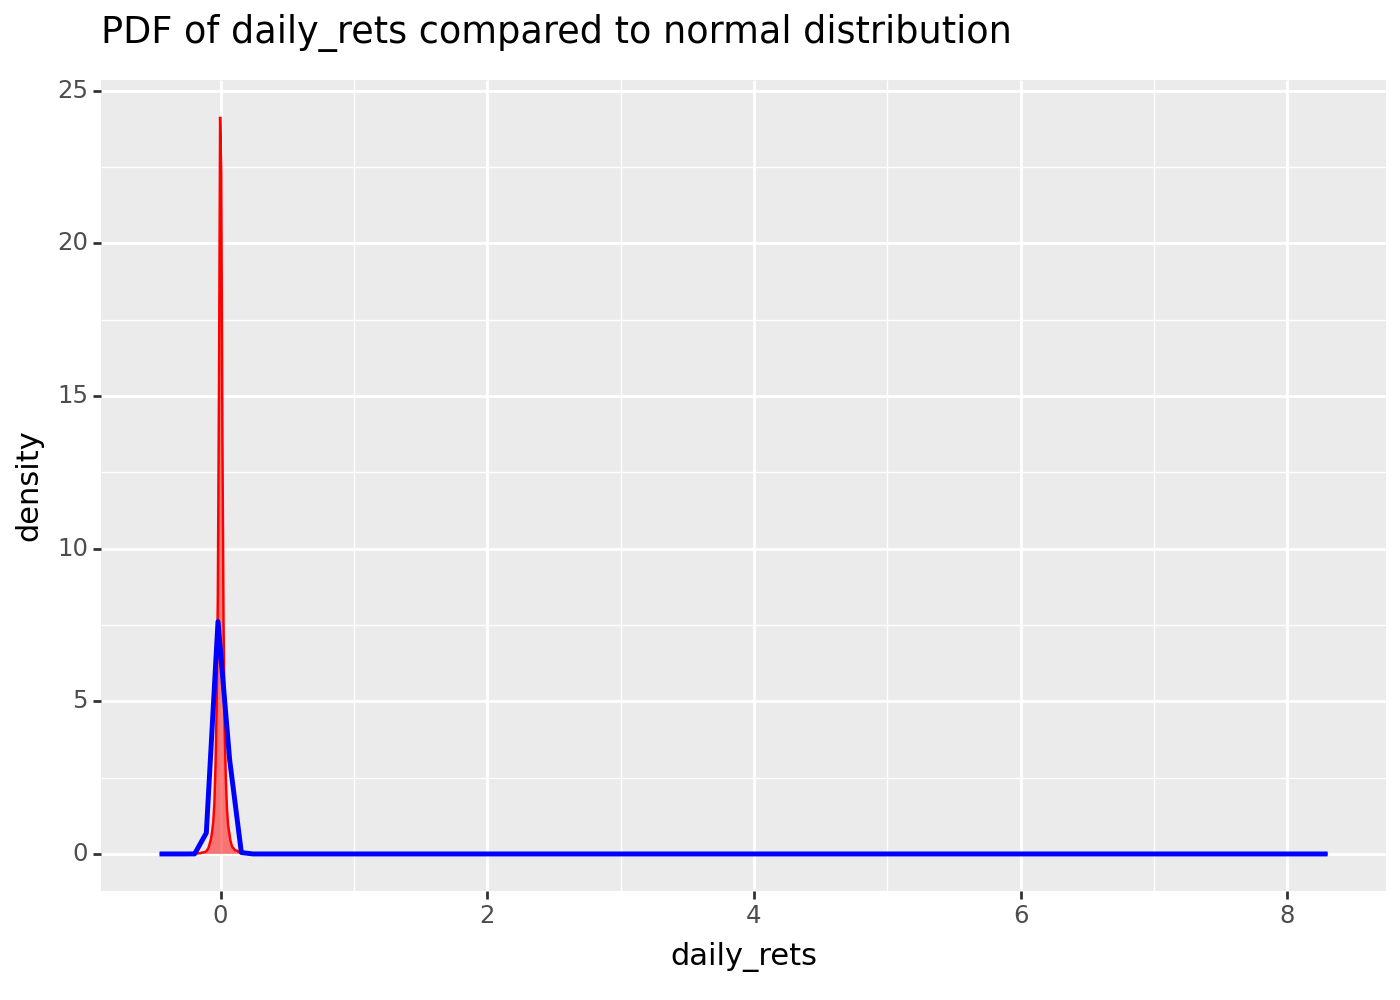

In [12]:
def plot_p9_pdf(data):
    column_name = data.columns[0]
    mean = data.mean().iloc[0]
    std = data.std().iloc[0]

    pdf_plot = (
        ggplot(data, aes(x=column_name)) +
        geom_density(color='red', fill='red', alpha=0.5) +
        stat_function(
            fun=norm.pdf,
            args=(mean, std),
            color='blue',
            size=1
        ) +
        ggtitle(f'PDF of {column_name} compared to normal distribution') +
        theme(figure_size=(7, 5))
    )

    print(pdf_plot)

daily_rets = top_eod_data['daily_rets']
daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)

#### **WRDS Market Data Bars (WRDS TAQ)**

WRDS TAQ has millisecond-level best bid and offer data.  However, downloading the full data series is not practical due to the hundreds of millions of rows per day.  Here, we use SQL to generate more manageable "bars" on the server side.

In [2]:
@lru_cache
def taq_nbbo_bars_on_date(tickers: list[str] | str, date:datetime.date, bar_minutes=30):
    assert bar_minutes==60 or (bar_minutes<=30 and 30%bar_minutes==0)
    date_str = date.strftime('%Y%m%d')
    year_str = date.strftime('%Y')
    tickers = (tickers,) if hasattr(tickers,'strip') else tuple(tickers)  # Allow single ticker as argument

    sql = f"""
            WITH windowable_nbbo AS (
                SELECT
                    sym_root AS ticker
                    , date
                    , time_m
                    , time_m_nano
                    , sym_root
                    , qu_cond
                    , best_bid
                    , best_bidsizeshares
                    , best_ask
                    , best_asksizeshares
                    , EXTRACT(HOUR FROM time_m) AS hour_of_day
                    , {bar_minutes} * DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) AS minute_of_hour
                    , ROW_NUMBER() OVER (PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) ORDER BY time_m DESC) AS rownum
                FROM taqm_{year_str}.complete_nbbo_{date_str} 
                WHERE 1=1
                  AND sym_root IN {tickers}
                  AND sym_suffix IS NULL
                  AND time_m > '09:30:00' AND time_m < '16:00:00'
            )
            SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
                ticker
                , date
                , date + (hour_of_day || ':' || minute_of_hour)::interval + ( '00:{bar_minutes}' )::interval AS window_time
                , best_bid
                , best_bidsizeshares
                , best_ask
                , best_asksizeshares
                , time_m AS time_of_last_quote
                , time_m_nano AS time_of_last_quote_ns
            FROM windowable_nbbo
            WHERE windowable_nbbo.rownum = 1
            """
    bars = db.raw_sql(sql)
    
    def _make_timestamp(r):
        t = datetime.datetime.combine(r.date, r.time_of_last_quote)#, tzinfo=pytz.timezone('America/New_York'))
        pdt = pd.to_datetime(t).tz_localize(pytz.timezone('America/New_York')) + pd.Timedelta(r.time_of_last_quote_ns, unit="ns")
        return pdt
    bars['time_of_last_quote'] = bars.apply(_make_timestamp, axis=1)
    del bars['time_of_last_quote_ns']
    bars['window_time'] = pd.to_datetime(bars['window_time']).dt.tz_localize(pytz.timezone('America/New_York'))
    return bars

,best_bid,best_bidsizeshares,best_ask,best_asksizeshares
count,26.000000,26.000000,26.000000,26.000000
mean,102.627692,3200.000000,102.638846,4646.153846
std,79.420994,3664.314397,79.422179,11076.758759
min,24.520000,300.000000,24.530000,200.000000
25%,24.710000,525.000000,24.720000,300.000000
50%,102.450000,1750.000000,102.460000,1750.000000
75%,180.325000,4250.000000,180.335000,3225.000000
max,181.610000,14500.000000,181.620000,55000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype                           
---  ------              --------------  -----                           
 0   ticker              26 non-null     object                          
 1   date                26 non-null     object                          
 2   window_time         26 non-null     datetime64[ns, America/New_York]
 3   best_bid            26 non-null     float64                         
 4   best_bidsizeshares  26 non-null     int64                           
 5   best_ask            26 non-null     float64                         
 6   best_asksizeshares  26 non-null     int64                           
 7   time_of_last_quote  26 non-null     datetime64[ns, America/New_York]
 8   datetime            26 non-null     datetime64[ns, America/New_York]
dtypes: datetime64[ns, America/New_York](3), float64(2), int64(2), object(2)
memory 

None

,ticker,date,window_time,best_bid,best_bidsizeshares,best_ask,best_asksizeshares,time_of_last_quote,datetime


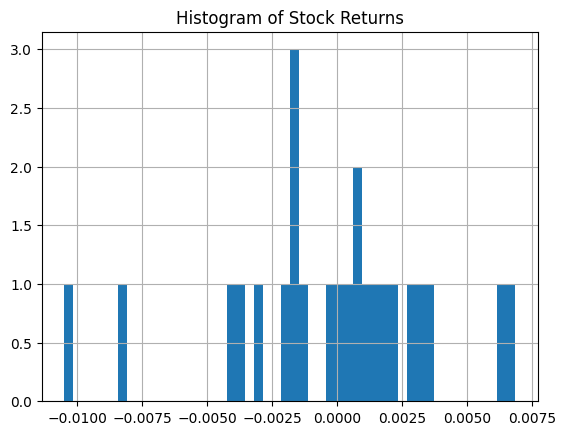

In [3]:
b20240229 = taq_nbbo_bars_on_date(('PLTR','AAPL'), date=datetime.date(2024,2,29))
b20240229['datetime'] = pd.to_datetime(b20240229['window_time'])
b20240229 = b20240229.sort_values(by=['ticker','datetime'],ascending=True)


# display(b20240229.loc[b20240229.ticker=='PLTR'])

display(b20240229.describe())
display(b20240229.info())

display(b20240229.loc[b20240229.best_bid.isna()])

b20240229['returns'] = b20240229.groupby('ticker')['best_bid'].pct_change()
b20240229['returns'].hist(bins=50)
plt.title("Histogram of Stock Returns")
plt.show()

#### **WRDS I/B/E/S Summary History**

​Refinitiv's Institutional Brokers' Estimate System (I/B/E/S) offers a comprehensive database of analyst forecasts and actual earnings data for publicly traded companies worldwide. The "Surprise History" within I/B/E/S specifically focuses on earnings surprises, providing insights into how actual earnings compare to analyst expectations over time.

Key components of the I/B/E/S Surprise History data include:
- Analyst Estimates: Forecasts for various financial metrics, notably Earnings Per Share (EPS), collected from a vast network of analysts. These estimates are aggregated to form consensus figures, serving as benchmarks for actual performance.​
- Actual Reported Earnings: The realized financial figures reported by companies, allowing for direct comparison against prior analyst projections.​




In [7]:
start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

query_ibes = f"""
    SELECT 
        *
    FROM 
        tr_ibes.surpsum
    WHERE
        1=1
        AND pyear>=2014
        AND fiscalp='QTR'
        AND measure='EPS'
        AND oftic IS NOT NULL
        AND anndats >= '{start_filing_date}'
        AND anndats <= '{end_filing_date}'
"""
surp_sum = db.raw_sql(query_ibes)

display(surp_sum.head())
display(surp_sum.tail())
display(surp_sum.describe())

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0,0000,TLMR,EPS,QTR,2014.0,3.0,1,2014-05-06,0.12,0.08000,0.01414,2.82845
1,0000,TLMR,EPS,QTR,2014.0,6.0,1,2014-08-06,0.27,0.13000,0.01225,11.43137
2,0000,TLMR,EPS,QTR,2014.0,9.0,1,2014-11-04,0.26,0.23200,0.05848,0.47879
3,0000,TLMR,EPS,QTR,2014.0,12.0,1,2015-01-30,0.16,0.17167,0.01169,-0.99800
4,0000,TLMR,EPS,QTR,2015.0,3.0,1,2015-04-30,0.12,0.17833,0.01835,-3.17927


,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
366971,ZZZ,ZZZ,EPS,QTR,2023.0,6.0,0,2023-08-10,0.42,0.48333,0.01966,-3.22078
366972,ZZZ,ZZZ,EPS,QTR,2023.0,9.0,0,2023-11-09,0.76,0.77000,0.07563,-0.13222
366973,ZZZ,ZZZ,EPS,QTR,2023.0,12.0,0,2024-03-06,0.56,0.52500,0.02074,1.68789
366974,ZZZ,ZZZ,EPS,QTR,2024.0,3.0,0,2024-05-07,0.28,0.35833,0.03430,-2.28357
366975,ZZZ,ZZZ,EPS,QTR,2024.0,6.0,0,2024-08-08,0.54,0.35500,0.05323,3.47555


,pyear,pmon,usfirm,actual,surpmean,surpstdev,suescore
count,366976.000000,366976.000000,366976.000000,3.605360e+05,3.669760e+05,2.645590e+05,256975.000000
mean,2018.999741,7.348102,0.502115,-1.313972e+05,-3.481676e+05,4.029730e+03,0.845682
std,3.099435,3.337119,0.499996,4.099740e+07,1.377658e+08,1.089106e+06,90.074564
min,2014.000000,1.000000,0.000000,-1.915200e+10,-6.048000e+10,0.000000e+00,-10010.134340
25%,2016.000000,3.000000,0.000000,0.000000e+00,1.500000e-02,1.940000e-02,-0.942820
50%,2019.000000,6.000000,1.000000,3.100000e-01,3.100000e-01,4.950000e-02,0.409390
75%,2022.000000,9.000000,1.000000,1.123237e+00,1.106000e+00,1.595300e-01,2.000000
max,2024.000000,12.000000,1.000000,2.475000e+05,2.100000e+05,4.725256e+08,25909.274190


#### **Fama-French Factor Returns**

We obtained the Fama-French factor returns (SMB, HML, RF and Mkt-RF) over the same data period as trading period (reference https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [8]:
ff_file_path = rf"../data/F-F_Research_Data_Factors_daily.csv"
ff_data = pd.read_csv(ff_file_path)
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')

display(ff_data.head())
display(ff_data.tail())

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.10,-0.25,-0.27,0.009
1,1926-07-02,0.45,-0.33,-0.06,0.009
2,1926-07-06,0.17,0.30,-0.39,0.009
3,1926-07-07,0.09,-0.58,0.02,0.009
4,1926-07-08,0.21,-0.38,0.19,0.009


,date,Mkt-RF,SMB,HML,RF
25875,2024-11-22,0.54,1.25,0.41,0.02
25876,2024-11-25,0.40,1.07,0.27,0.02
25877,2024-11-26,0.42,-0.92,-0.71,0.02
25878,2024-11-27,-0.39,0.28,0.47,0.02
25879,2024-11-29,0.54,0.14,-0.64,0.02


### Data Cleansing/Merge

#### Earnings Surprise Data
Below we are: 
- Converting "anndats" to a proper datetime, dropping any rows where it’s missing.
- Extracting the year from each announcement date, which we will use as a proxy for determining which data is consistent throughout.
- Filtering to keep only tickers that appear in every year of our date range   (year_beginning_filter through year_end_filter).
- Further ensuring each ticker has 4 quarters of data each year for consistently quarterly coverage.
- Removing any ticker that fails these conditions, leaving a final set of tickers meeting both the year coverage and 4-quarter criteria.
- Printing out the number of Investable universe of stocks for this dataset

In [12]:
# Cleaning the surprise Data
surp_sum['anndats'] = pd.to_datetime(surp_sum['anndats'], errors='coerce')
surp_sum = surp_sum[surp_sum['anndats'].notnull()]

surp_sum['year'] = surp_sum['anndats'].dt.year

years_required = set(range(year_beginning_filter, year_end_filter+1))

coverage = surp_sum.groupby('oftic')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda x: years_required.issubset(x))].index
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers)]

quarter_counts = (
    surp_sum
    .groupby(['oftic', 'year'])
    .size()
    .reset_index(name='count_per_year')
)

quarter_counts_ok = quarter_counts[quarter_counts['count_per_year'] >= 4]

annual_coverage = quarter_counts_ok.groupby('oftic')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda x: years_required.issubset(x))].index

# Filtering out stocks that dont have 4 quarters of data for each year
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers_4q)]
surp_sum['oftic'].nunique()

3632

#### Zack's Fundamental B Dataset
Below we are:
- Setting a market value threshold of $500 million to ensure our data stays above that amount throughout the entire date range.
- Calculating new metrics for use in rankings, P/E, EV/EBITDA, and YoY growth in revenue and price
- Ensuring we have consistent quarterly data for all the metrics below
- Printing out the unique amount of filters that pass these filters.
- We then filter the remaining tickers on what we have in the filtered surprise dataset to end up with 327 individual stocks that pass our criteria

In [17]:
# Setting The Market Cap Threshold to Filter out Smaller Companies
mkt_cap_threshold = 500

# Selecting the metrics we plan to include in our strategy
zacks_df = zacks_df.copy()
zacks_df = zacks_df[zacks_df['per_end_date'].notnull() & (zacks_df['per_type'] == 'Q')]
zacks_df.dropna(subset=['tot_revnu','ebitda','eps_basic_net','mkt_val','ep_val','shares_out'], inplace=True)
zacks_df.sort_values(['ticker','per_end_date'], inplace=True)

# Creating Other metrics we plan to use as indicators
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filing_date, end_filing_date)]
zacks_df['price'] = zacks_df['mkt_val'] / zacks_df['shares_out']
zacks_df['PE'] = zacks_df['price'] / zacks_df['eps_basic_net']
zacks_df['EV_EBITDA'] = zacks_df['ep_val'] / zacks_df['ebitda']
zacks_df['rev_yoy_growth'] = zacks_df.groupby('ticker')['tot_revnu'].pct_change(periods=4)
zacks_df['price_yoy_growth'] = zacks_df.groupby('ticker')['price'].pct_change(periods=4)

# Filtering Stocks to a smaller date range
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filter_date, end_filter_date)]
zacks_df['year'] = zacks_df['per_end_date'].dt.year

# Filtering out stocks with Market Cap below the threshold
min_cap_by_ticker = zacks_df.groupby('ticker')['mkt_val'].transform('min')
zacks_df = zacks_df[min_cap_by_ticker >= mkt_cap_threshold]

years_required = set(range(year_beginning_filter, year_end_filter + 1))
coverage = zacks_df.groupby('ticker')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers)]

counts = zacks_df.groupby(['ticker', 'year']).size().reset_index(name='count_per_year')
counts_ok = counts[counts['count_per_year'] >= 4]
annual_coverage = counts_ok.groupby('ticker')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers_4q)]
zacks_df['ticker'].nunique()

372

In [18]:
# Filtering the surprise data on market cap requirement
valid_tickers = set(zacks_df['ticker'].unique())
surp_sum_filtered = surp_sum[surp_sum['oftic'].isin(valid_tickers)]
surp_sum_filtered['oftic'].nunique()

surp_sum_filtered.head()

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
266,001J,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014
267,001J,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014
268,001J,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014
269,001J,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015
270,001J,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015


#### Transforming the primary final dataset
Below we are:
- Assign tickers to bins based on their avg_EPS to ensure we are comparing similar magnitudes of percent changes.
- We then transform the daily stock data obtained from the 'QUOTEMEDIA/PRICES' dataset to obtain the next day adjusted close and compute the return between those two days to capture the initial movement of the earnings surprise
- We merge these two datasets and bring in the relevant columns.
- The avg_eps_estimate is then calculated from subtracting the surprise mean from the actual EPS.
- Pct_surprise is calculated as the (average surprise)/ (the next day return)
- We then calculate the primary metric 'surprise_vs_move' which is simply the pct_surprise/(next day return). This should help us gauge how much the stock moved relative to it's surprise number
- The data is then translated into a z-score subtracting the mean of the bin it is in as well as dividing by the standard deviation of the same bin.

In [19]:
# Separating the Surprises into Bins
surp_sum_filtered['avg_eps'] = surp_sum_filtered.groupby('ticker')['actual'].transform('mean')
bins = [-np.inf, 0, 0.5, 1, 2,  np.inf]
labels = [
    "Negative",
    "0 to 0.5",
    "0.5 to 1.0",
    "1.0 to 2.0",
    ">2.0"
]

surp_sum_filtered['avg_eps_bin'] = pd.cut(surp_sum_filtered['avg_eps'], bins=bins, labels=labels)


surp_sum_filtered.groupby('avg_eps_bin')['ticker'].nunique()

avg_eps_bin
Negative       31
0 to 0.5      127
0.5 to 1.0    121
1.0 to 2.0     84
>2.0           45
Name: ticker, dtype: int64

In [27]:
# Sorting close prices for merge
eod_data = top_eod_data.copy()

# Creating the next day close price and next day return
eod_data['next_close'] = eod_data.groupby('ticker')['adj_close'].shift(-1)
eod_data['next_day_return'] = (
    eod_data['next_close'] / eod_data['adj_close'] - 1
)

eod_data['date'] = pd.to_datetime(eod_data['date'])
surp_sum_filtered['anndats'] = pd.to_datetime(surp_sum_filtered['anndats'])

# Merging the surprise data with the EOD data
surp_sum_filtered = surp_sum_filtered.merge(
    eod_data[['ticker','date','adj_close','next_close','next_day_return']],
    how='left',
    left_on=['oftic','anndats'],
    right_on=['ticker','date']
)

surp_sum_filtered.head()

,ticker_x,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,avg_eps,avg_eps_bin,ticker_y,date,adj_close,next_close,next_day_return
0,001J,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014,0.243571,0 to 0.5,KN,2014-04-28,30.92,29.52,-0.045278
1,001J,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014,0.243571,0 to 0.5,KN,2014-07-28,29.08,28.69,-0.013411
2,001J,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014,0.243571,0 to 0.5,KN,2014-10-27,18.80,19.40,0.031915
3,001J,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015,0.243571,0 to 0.5,KN,2015-02-12,21.64,18.59,-0.140943
4,001J,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015,0.243571,0 to 0.5,KN,2015-04-23,21.24,20.08,-0.054614


In [28]:
# Calculating avg_estimate
surp_sum_filtered['eps_estimate'] = surp_sum_filtered['actual'] - surp_sum_filtered['surpmean']

# Calculating percent surprise
surp_sum_filtered['pct_surprise'] = (
    surp_sum_filtered['surpmean'] / surp_sum_filtered['eps_estimate']
)

# Creating a metric to estimate the drift available
surp_sum_filtered['surprise_vs_move'] = (
    surp_sum_filtered['pct_surprise'] / surp_sum_filtered['next_day_return']
)
surp_sum_filtered['surprise_vs_move'] = surp_sum_filtered['surprise_vs_move'].replace([np.inf, -np.inf], 0)


In [29]:
surp_sum_filtered['zscore_surprise_vs_move'] = (
    surp_sum_filtered
    .groupby('avg_eps_bin')['surprise_vs_move']
    .transform(lambda x: (x - x.mean()) / x.std())
)
surp_sum_filtered.head()

,ticker_x,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,avg_eps,avg_eps_bin,ticker_y,date,adj_close,next_close,next_day_return,eps_estimate,pct_surprise,surprise_vs_move,zscore_surprise_vs_move
0,001J,KN,EPS,QTR,2014.0,3.0,1,2014-04-28,0.32,0.30333,0.01155,1.44338,2014,0.243571,0 to 0.5,KN,2014-04-28,30.92,29.52,-0.045278,0.01667,18.196161,-401.875208,-0.018734
1,001J,KN,EPS,QTR,2014.0,6.0,1,2014-07-28,0.21,0.17600,0.00894,3.80143,2014,0.243571,0 to 0.5,KN,2014-07-28,29.08,28.69,-0.013411,0.03400,5.176471,-385.978884,-0.018337
2,001J,KN,EPS,QTR,2014.0,9.0,1,2014-10-27,0.38,0.40500,0.05505,-0.45417,2014,0.243571,0 to 0.5,KN,2014-10-27,18.80,19.40,0.031915,-0.02500,-16.200000,-507.600000,-0.021374
3,001J,KN,EPS,QTR,2014.0,12.0,1,2015-02-12,0.14,0.34125,0.02232,-9.01617,2015,0.243571,0 to 0.5,KN,2015-02-12,21.64,18.59,-0.140943,-0.20125,-1.695652,12.030791,-0.008396
4,001J,KN,EPS,QTR,2015.0,3.0,1,2015-04-23,0.06,0.02750,0.01832,1.77373,2015,0.243571,0 to 0.5,KN,2015-04-23,21.24,20.08,-0.054614,0.03250,0.846154,-15.493369,-0.009083


## Data Analysis

## Strategy Implementation

## Backtesting

## Performance Analysis

## References